## Census Data

In [11]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import folium
from shapely import BufferCapStyle

In [2]:
df = pd.read_csv('census_1km.csv', sep = ';')
df = df.drop(axis = 1, columns = ["Gitter_ID_1km *"])
df.head()

,x_mp_1km_1,y_mp_1km_1,Einwohner,Alter_D,unter18_A,ab65_A,Auslaender_A,HHGroesse_D,Leerstandsquote,Wohnfl_Bew_D,Wohnfl_Whg_D
0,4314500,3367500,3,-9.0,0.0,0.0,0.00,-1.0,-1.0,-9.0,-1.0
1,4331500,3372500,3,-9.0,0.0,100.0,0.00,-1.0,-1.0,-9.0,-1.0
2,4315500,3378500,3,-9.0,0.0,0.0,0.00,-1.0,-1.0,-9.0,-1.0
3,4316500,3379500,3,-9.0,0.0,0.0,100.00,-1.0,-1.0,-1.0,-1.0
4,4335500,3379500,7,-9.0,-9.0,0.0,57.14,1.4,-1.0,-1.0,-1.0


In [3]:
# create geometry element from point coordinates
geometry = gpd.points_from_xy(df.x_mp_1km_1, df.y_mp_1km_1, crs="EPSG:3035")

# create new geopandas dataframe dropping old columns
gdf = gpd.GeoDataFrame(df, geometry = geometry)
gdf = gdf.drop(columns = ['x_mp_1km_1','y_mp_1km_1'])

gdf = gdf.to_crs(4326)
gdf.head(3)

,Einwohner,Alter_D,unter18_A,ab65_A,Auslaender_A,HHGroesse_D,Leerstandsquote,Wohnfl_Bew_D,Wohnfl_Whg_D,geometry
0,3,-9.0,0.0,0.0,0.0,-1.0,-1.0,-9.0,-1.0,POINT (9.90225 53.41535)
1,3,-9.0,0.0,100.0,0.0,-1.0,-1.0,-9.0,-1.0,POINT (10.15807 53.46022)
2,3,-9.0,0.0,0.0,0.0,-1.0,-1.0,-9.0,-1.0,POINT (9.91710 53.51421)


<AxesSubplot: >

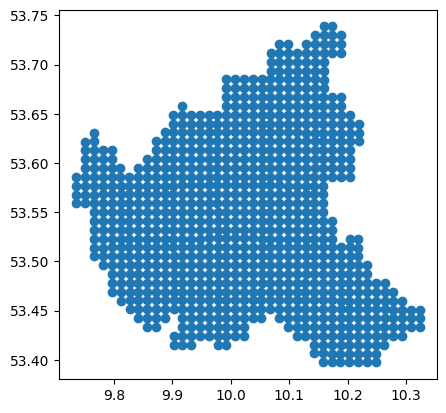

In [4]:
gdf.plot()

In [5]:
gdf_3395 = gdf.to_crs(epsg=3395)
bbox = gdf_3395.buffer(840, cap_style=3)
bbox

0      POLYGON ((1103153.726 7026705.233, 1103153.726...
1      POLYGON ((1131630.635 7035069.700, 1131630.635...
2      POLYGON ((1104806.459 7045146.921, 1104806.459...
3      POLYGON ((1106482.769 7046827.132, 1106482.769...
4      POLYGON ((1138369.515 7046793.978, 1138369.515...
                             ...                        
857    POLYGON ((1111511.685 7065317.050, 1111511.685...
858    POLYGON ((1139987.714 7028345.404, 1139987.714...
859    POLYGON ((1136691.275 7046798.864, 1136691.275...
860    POLYGON ((1094751.254 7040095.898, 1094751.254...
861    POLYGON ((1118223.493 7033411.817, 1118223.493...
Length: 862, dtype: geometry

<AxesSubplot: >

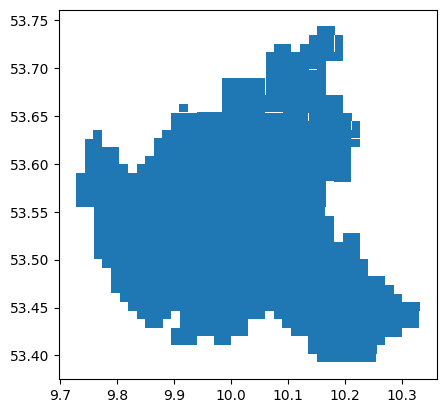

In [6]:
envgdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bbox))
bbox_4326 = gpd.GeoDataFrame(envgdf, crs='EPSG:3395')
bbox_4326 = bbox_4326.to_crs(epsg=4326)
bbox_4326.plot()

In [7]:
gdf['bbox'] = bbox_4326
gdf_top50 = gdf.head(50)
gdf.head(1)

,Einwohner,Alter_D,unter18_A,ab65_A,Auslaender_A,HHGroesse_D,Leerstandsquote,Wohnfl_Bew_D,Wohnfl_Whg_D,geometry,bbox
0,3,-9.0,0.0,0.0,0.0,-1.0,-1.0,-9.0,-1.0,POINT (9.90225 53.41535),"POLYGON ((9.90980 53.41986, 9.90980 53.41085, ..."


In [15]:
map = folium.Map(location=[53.41535, 9.90225], tiles="CartoDB Positron", zoom_start=9)
for _, r in gdf.iterrows():
    sim_geo = gpd.GeoSeries(r["bbox"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["Alter_D"]).add_to(geo_j)
    geo_j.add_to(map)


map

In [9]:
gdf_centroid = gdf_top50["geometry"]
gdf_bbox = gdf_top50["bbox"]
gdf_bbox.head()

0    POLYGON ((9.90980 53.41986, 9.90980 53.41085, ...
1    POLYGON ((10.16561 53.46473, 10.16561 53.45572...
2    POLYGON ((9.92465 53.51871, 9.92465 53.50972, ...
3    POLYGON ((9.93970 53.52771, 9.93970 53.51871, ...
4    POLYGON ((10.22615 53.52753, 10.22615 53.51853...
Name: bbox, dtype: geometry

In [10]:
gdf_centroid.to_file('census_centroid_data.json', driver ='GeoJSON',mode='w')
gdf_bbox.to_file('census_bbox_data.json', driver ='GeoJSON', mode='w')